# Dog Breed Identification

In [1]:
# imports

# Data munging
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Py modules
import random
from random import randint
import time

# Make it torch-y
import torch
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# Torch-y vision stuff
import torchvision
import torchvision.models as models
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder

# Loader bars
from tqdm.notebook import tqdm

# Image handling
from PIL import Image
from scipy import ndimage

# ML
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# System stuff
import os


## Getting Data

Some early analysis in this notebook is inspired by https://www.kaggle.com/kmldas/dog-breed-classification-beginner-s-tutorial , and was used to do some quick prototyping rather than a full-blown analysis. Don't interpret this as my own work, it was intended to be a quick introduction to image transformations for Computer Vision.

In [2]:
TRAIN_DIR = "train"
TEST_DIR  = "test"

train_csv = "labels.csv"
test_csv  = "submission.csv"

In [3]:
init_data_df = pd.read_csv(train_csv)
init_data_df.head(10)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


In [4]:
class ProcessedDataset(Dataset):
    
    def __init__(self, df, DIR, data_type = None):
        
        # Available parameters
        self.df = df
        self.dir = DIR
        self.data_type = data_type
        
        # Do preprocessing
        self.add_img_path()
        self.add_labels()
    
    def map_path(self, ID):
        return os.path.join(self.dir, ID + ".jpg")
    
    def add_img_path(self):
        """Adds a column with respective image paths"""
        #self.df['img_path'] = self.df['id'].apply(lambda x: self.map_path(x))
        self.df['img_path'] = self.df['id'].map(self.map_path)
    
    def add_labels(self):
        """Generates numerical labels from categories"""
        
        # Get sorted unique labels
        self.label_names = self.df['breed'].unique()
        self.labels_sorted = self.label_names.sort()
        
        # Create dict mappings
        self.labels = dict(zip(range(len(self.label_names)), self.label_names))
        self.labels_rev = dict(zip(self.label_names, range(len(self.label_names))))
        
        # Set new df using mapping
        self.df['label'] = self.df['breed'].map(self.labels_rev)
        
    def show_images(self, n_rows, n_cols):
        """Plots a grid of images"""
        
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15),
                                subplot_kw={'xticks': [], 'yticks': []})
        
        for i, ax in enumerate(axes.flat):
            ax.imshow(plt.imread(self.df.loc[i, 'img_path']))
            ax.set_title(self.df.loc[i, 'breed'])
            
        plt.tight_layout()
        plt.show()
        
    def __len__(self):
        """Required for Torch Dataset"""
        return len(self.df)
    
    def __getitem__(self, idx):
        """Required for Torch Dataset to return single items"""
        
        # Retrieve image id and corresponding label
        img_id = self.df.loc[idx, 'id']
        img_label = self.df.loc[idx, 'label']
        
        # Open the image
        img_path = os.path.join(self.dir, str(img_id) + ".jpg")
        img = Image.open(img_path)
        
        # Transform the image
        #if self.transform:
        img = self.transform(img)
            
        return img, img_label
    
    def transform(self, img):
        """Function to transform images"""
        imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        if self.data_type == "train":
            composed = T.Compose([
                T.Resize((300,300)),
                T.ColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1, hue = 0.1),
                T.RandomHorizontalFlip(),
                T.RandomRotation(10),
                T.ToTensor(),
                T.Normalize(*imagenet_stats, inplace=True)
            ])
        else:
            composed = T.Compose([
                T.Resize((300,300)),
                T.ToTensor(),
                T.Normalize(*imagenet_stats)
            ])
        return composed(img)

In [5]:
data_df_proc = ProcessedDataset(init_data_df, TRAIN_DIR)
data_df = data_df_proc.df

In [6]:
data_df.head()

,id,breed,img_path,label
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg,49


In [7]:
num_images = len(data_df['id'])
num_labels = len(data_df_proc.label_names)

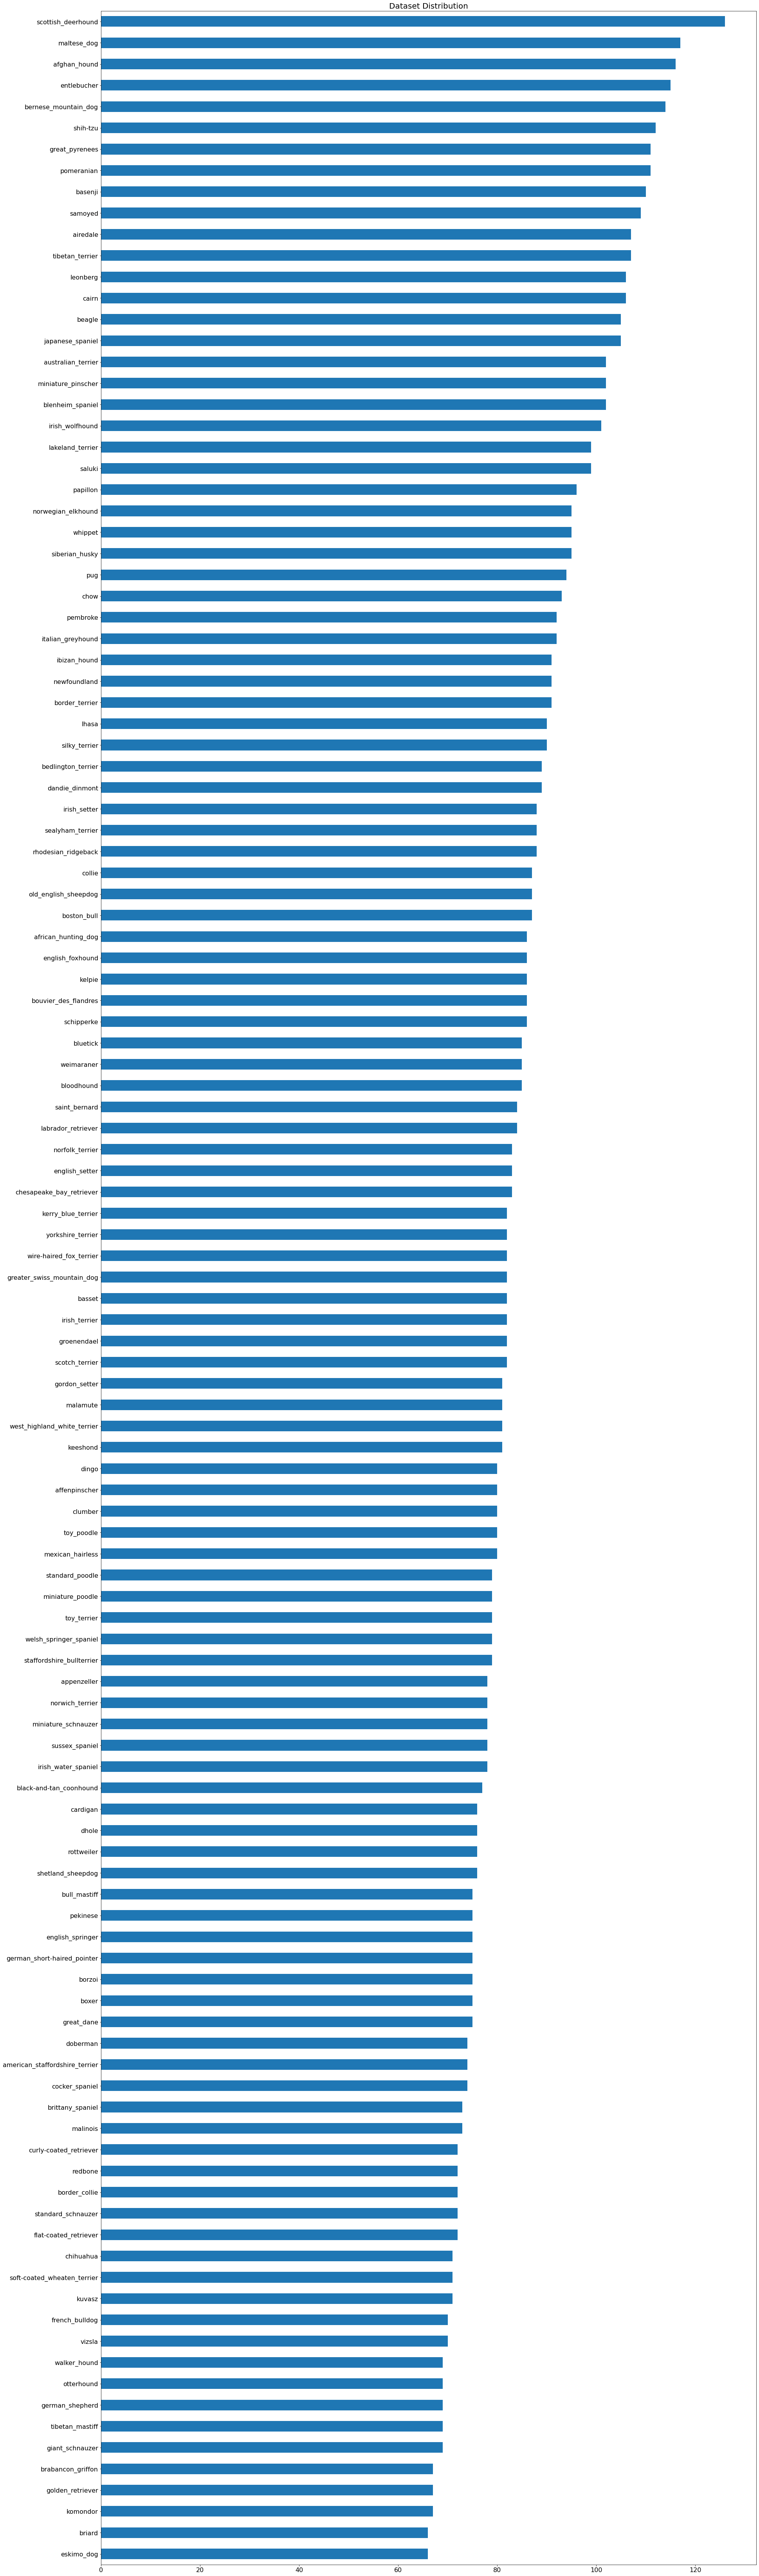

In [8]:
bar = data_df["breed"].value_counts(ascending=True).plot.barh(figsize = (30,120))
plt.title("Dataset Distribution", fontsize = 20)
bar.tick_params(labelsize=16)
plt.show()

## Investigate Images

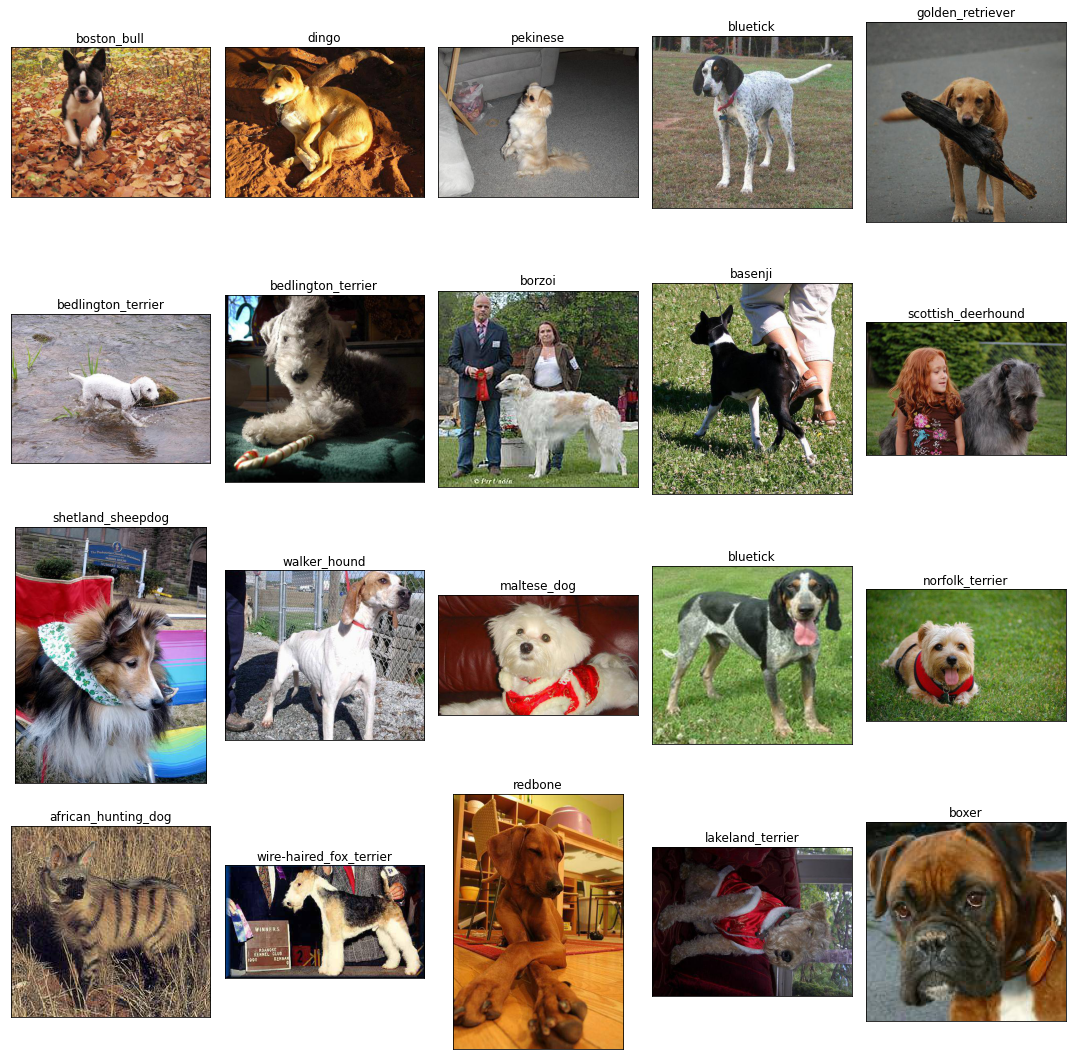

In [9]:
data_df_proc.show_images(n_rows = 4, n_cols = 5)

In [10]:
# Make train/validation split - bit hacky
X_train, X_val, _, _ = train_test_split(data_df, data_df['label'], test_size=0.2, random_state=42)

In [11]:
train_ds = ProcessedDataset(X_train.reset_index(), TRAIN_DIR, data_type = "train")
val_ds   = ProcessedDataset(X_val.reset_index(),   TRAIN_DIR)

In [12]:
#val_ds.show_images(5,5)

In [13]:
# Get dataloaders
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

In [14]:
#train_ds.show_images(4,5)

In [17]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16,8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


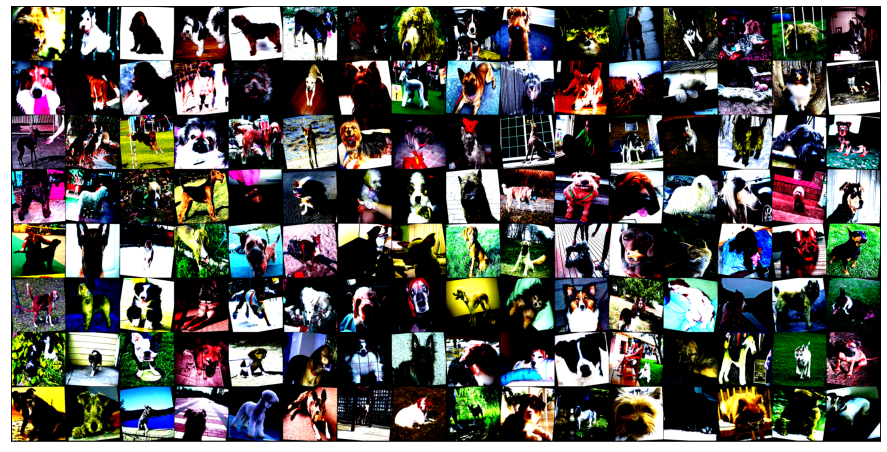

In [19]:
show_batch(train_dl, invert=False)